In [1]:
import pandas as pd
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
def make_six_digit_list(input_list):
    six_digit_list = []

    for item in input_list:
        # 현재 항목의 길이를 확인
        item_str = str(item)
        item_len = len(item_str)

        if item_len < 6:
            # 6자리가 안되는 항목은 앞에 0을 채워서 6자리로 만듭니다.
            zero_padding = '0' * (6 - item_len)
            six_digit_item = zero_padding + item_str
            six_digit_list.append(six_digit_item)
        else:
            # 이미 6자리인 경우 그대로 유지
            six_digit_list.append(item_str)

    return six_digit_list
def filter_df(df): #데이터프레임 필터링
    # 첫 번째 열에서 같은 값을 가진 행의 수를 계산합니다.
    row_counts = df['0'].value_counts()

    # 가장 많은 행의 수를 찾습니다.
    max_row_count = row_counts.max()

    # 가장 많은 행의 수에 해당하는 행만 분류합니다.
    filtered = pd.DataFrame(df[df['0'].isin(row_counts[row_counts == max_row_count].index)])

    return filtered
def Prediction():
    # 데이터 로드   
    pred_df = pd.read_csv('/Users/moon/Desktop/Moon SeungHoo/Stock_Machine_Learning/StockData_Pred_240215.csv',low_memory=False)

    filter_pred= filter_df(pred_df)

    # 예측에 필요한 데이터 
    pred_ticker = list(OrderedDict.fromkeys(filter_pred['0'])) #종목코드 저장

    # 불필요한 데이터 삭제
    filter_pred = filter_pred.drop({'0','1','7'},axis=1) #종목코드, 날자, 상승율 삭제
    
    model_1 = tf.keras.models.load_model("GRU_Model_8L_64_3%.h5")
    Pred = model_1.predict(filter_pred)
    Pred = Pred.round(3)
    
    # 5% 이상 오를 종목 식별
    rising_stocks = [ticker for i, ticker in enumerate(pred_ticker) if Pred[i] > 0.9]

    # T_pred를 기준으로 내림차순 정렬
    rising_stocks_sorted = sorted(rising_stocks, key=lambda i: Pred[pred_ticker.index(i)], reverse=True)
    rising_stocks_sorted = list(map(str, rising_stocks_sorted))
    result = list(set(rising_stocks_sorted))
    result = make_six_digit_list(result)
    sorted_list = result[:1]
    # sorted_list = result
    print("내일 5% 이상 상승할 종목:", sorted_list)

    return sorted_list

예측

In [3]:
pred_1 = Prediction()

3/3 [==============================] - 1s 9ms/step
내일 5% 이상 상승할 종목: ['024060']


예측한 결과 확인

             Open   High    Low  Close    Volume    Change
Date                                                      
2024-02-14  10380  11980  10050  10850  11267738  0.083916
2024-02-15  10510  11460  10400  10880   3802661  0.002765


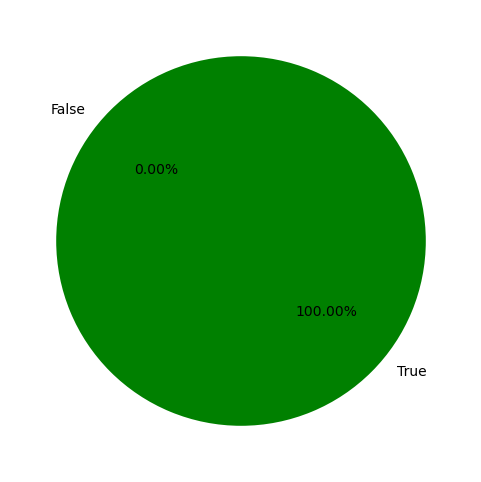

In [4]:
def check_price_increase(stock_codes):
    result = {}
    
    for code in stock_codes:
        df = fdr.DataReader(code, '2024-02-14', '2024-02-15')  # 전날을 포함하도록 날짜 범위 수정
        print(df)
        if len(df) < 2:
            result[code] = False
        else:
            # 전날 종가로부터 당일 고가까지의 변동률 계산
            percentage_change = (df['High'].iloc[-1] - df['Close'].iloc[-2]) / df['Close'].iloc[-2] * 100

            # 변동률이 5% 이상인 경우 참, 그 외에는 거짓으로 설정
            if percentage_change >= 3.3:
                result[code] = True
            else:
                result[code] = False
    return result

result_TF = check_price_increase(pred_1)
result_TF = list(result_TF.values())
# True와 False의 개수를 세어 비율을 계산
true_count = sum(result_TF)
false_count = len(result_TF) - true_count
# 비율을 파이그래프로 표현
labels = ['True', 'False']
sizes = [true_count, false_count]
colors = ['green', 'red']
# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140)
# 그래프 표시
plt.show() 